In [3]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn.functional as func
from torch import Tensor
from typing import Type
from torch.utils.data import Dataset, DataLoader
#from torchvision.models import resnet152
#from torchvision.models import ResNet152_Weights
import torchvision
from torchvision.io import read_image
#import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim

from models import ResNet152, VanillaResNet
from train import train1Epoch, test1Epoch
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True
import seaborn as sns

import os
import cv2
import argparse
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from scipy.stats import pearsonr
import random
import csv

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device, torch.version.cuda

('cuda', '11.8')

In [5]:
username = 'ddavilag'

VanillaResNet.pt: Model A (Just Original Images)<br>
VanillaResNet+Data.pt: Model B (Original X-Rays with Clinical Data)<br>
SegmentedResNet.pt: Model C (Original X-Rays, Heart & Lung Segmentations)<br>
ResNetCombo+Data2.pt: Model D (Original X-Rays, Heart & Lung Segmentations, with Clinical Data)<br>

In [6]:
MODEL_TYPE = 'VanillaResNet'
#MODEL_TYPE = 'VanillaResNet+Data'
#MODEL_TYPE = 'SegmentedResNet'
#MODEL_TYPE = 'ResNetCombo+Data2'

WORKDIR = os.getcwd()

#DataHub:
#DATADIR = f'/home/{username}/teams/dsc-180a---a14-[88137]/'
#SAVEDIR = f'/home/{username}/teams/dsc-180a---a14-[88137]/models'

#Local:
DATADIR = os.path.join(WORKDIR, 'data')
SAVEDIR = os.path.join(WORKDIR, 'models')
MODELDIR = os.path.join(SAVEDIR, f'{MODEL_TYPE}.pt')

## Loading Dataset + Images

In [ ]:
data = pd.read_csv(os.path.join(DATADIR,'data_fixed.csv'))
data['bnpp_log'] = data.bnpp.apply(lambda x: np.log10(x))
if MODEL_TYPE == 'VanillaResNet' or MODEL_TYPE == 'SegmentedResNet':
    print('loading Vanilla csv!')
    data.drop(columns=['bmi','cr','PNA','AcuteHF'], inplace=True)
#data.drop(columns=['cardio_edema','bmi','cr','PNA','AcuteHF'], inplace=True)
#data.drop(columns=['PNA','AcuteHF'], inplace=True)
data.bnpp_log = data.bnpp_log.astype('float32')
display(data.head(10))

data = data.to_numpy()

,unique_key,bnpp,cardio_edema,bmi,cr,PNA,AcuteHF,bnpp_log
0,Abachug_50267230_img1,418.0,1,25.51,0.61,1,0,2.621176
1,Abadik_50217497_img1,2161.0,1,31.38,1.31,0,0,3.334655
2,Abafouck_52403307_img1,118.0,0,33.81,0.66,0,0,2.071882
3,Abagash_52691625_img1,49.9,0,30.64,0.64,0,0,1.698101
4,Abakleem_50725934_img1,20029.0,1,34.81,10.54,0,0,4.301659
5,Abaphos_51936331_img1,1657.0,1,26.46,7.26,0,0,3.219322
6,Abcifisk_52639558_img1,120.0,0,39.75,0.88,0,0,2.079181
7,Abdisey_52768446_img1,283.0,0,24.12,3.75,0,0,2.451787
8,Abebey_51516292_img1,955.0,1,22.66,0.50,1,0,2.980003
9,Abefik_50148616_img1,4761.0,1,26.95,1.07,1,0,3.677698


In [ ]:
data.to_csv('data.csv', index=False)

In [ ]:
# loading the image data with 3 channels: original, lungs seg, heart seg (12.8 GB)
if MODEL_TYPE == 'VanillaResNet' or MODEL_TYPE == 'VanillaResNet+Data':
    print('loading Vanilla images!')
    hf = h5py.File(os.path.join(DATADIR,'original_images.hdf5'), 'r')
    train_imgs = hf['train_images'][:]
    valid_imgs = hf['valid_images'][:]
    test_imgs = hf['test_images'][:]
    
else:
    try:
        train_imgs = np.load(os.path.join(DATADIR,'train.npy'), allow_pickle=True)
        valid_imgs = np.load(os.path.join(DATADIR,'valid.npy'), allow_pickle=True)
        test_imgs = np.load(os.path.join(DATADIR,'test.npy'), allow_pickle=True)
    except:
        images = np.load(os.path.join(DATADIR,'final.npy'), allow_pickle=True)
        train_imgs = images[0:13295]
        valid_imgs = images[13295:14957]
        test_imgs = images[14957:]
print('loaded images!')

loaded images!


### Sanity Checks for Data Validity

Dataset Shape: (16619, 8)
Images Dataset Shape: (13295, 256, 256, 3)
Specific Image Shape: (256, 256, 3)
View First Image:


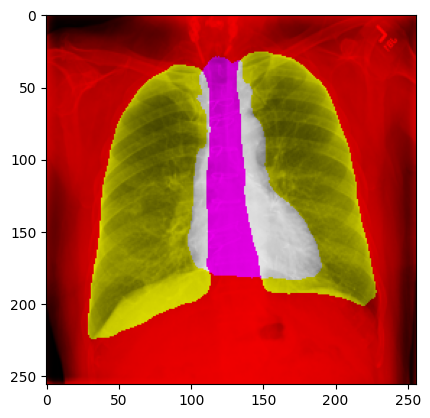

In [ ]:
print('Dataset Shape:', data.shape)
print('Images Dataset Shape:', train_imgs.shape)
print('Specific Image Shape:', train_imgs[0].shape)
print('View First Image:')
plt.imshow(torch.from_numpy(np.transpose(train_imgs[0])).permute(2, 1, 0))
# need to take transpose of images to get them to the right shape, 
# then permute to get them to appear upright for imshow
plt.show()

## Dataset Class + Loader
Dataset class: <br>
inputs = numpy array of data, numpy array of images <br>
outputs = PyTorch tensors of images (original, lung, heart), bnpp value log, (bmi, cr), edema<br><br>
DataLoaders:<br>
train = index 0-13295 (80% total), shuffled, batch = 12<br>
valid = index 13295-14957 (10% total), not shuffled, batch = 12<br>
test = index 14957-16619 (10% total), not shuffled, batch = 1<br>

In [ ]:
class PreprocessedImageDataset(Dataset):
    def __init__(self, df, arr, model_type):
        self.df = df #numpy array of data
        self.arr = arr #numpy pickle array of images (original, lung, heart)
        self.model_type = model_type

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df[idx]
        img = torch.from_numpy(np.transpose(self.arr[idx]))

        if self.model_type == 'VanillaResNet' or self.model_type == 'SegmentedResNet':
            #returns image, bnpp value log, edema
            return img, torch.tensor(row[-1], dtype=torch.float32), torch.tensor(row[2], dtype=torch.int)

        #returns image, bnpp value log, (bmi, cr, PNA, AcuteHF), edema
        return img, torch.tensor(row[7], dtype=torch.float32), torch.tensor([row[3],row[4],row[5],row[6]], dtype=torch.float32), torch.tensor(row[2], dtype=torch.int)

In [ ]:
batch_size = 12 #maybe change to 16, 8
num_workers = 0
pin_memory = False

train_set = PreprocessedImageDataset(df=data[0:13295], arr=train_imgs, model_type=MODEL_TYPE)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

valid_set = PreprocessedImageDataset(df=data[13295:14957], arr=valid_imgs, model_type=MODEL_TYPE)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

test_set = PreprocessedImageDataset(df=data[14957:], arr=test_imgs, model_type=MODEL_TYPE)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

### Sanity Check on Dataset

Image Tensor: tensor([[[0.4078, 0.3882, 0.3725,  ..., 0.3294, 0.4824, 0.6471],
         [0.3451, 0.3137, 0.2824,  ..., 0.2784, 0.4235, 0.6000],
         [0.2863, 0.2588, 0.2314,  ..., 0.2275, 0.3686, 0.5529],
         ...,
         [0.6745, 0.5961, 0.5137,  ..., 0.1059, 0.1059, 0.1059],
         [0.6078, 0.5569, 0.5098,  ..., 0.2000, 0.1961, 0.1961],
         [0.5804, 0.5569, 0.5412,  ..., 0.3255, 0.3333, 0.3451]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.00

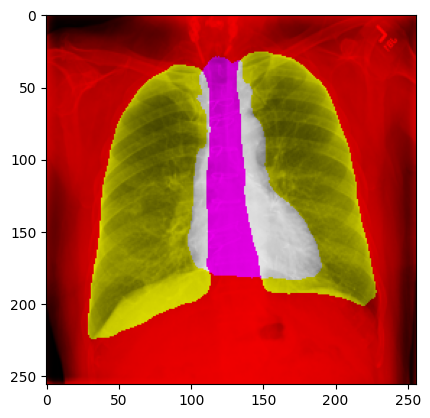

In [ ]:
if MODEL_TYPE == 'VanillaResNet' or MODEL_TYPE == 'SegmentedResNet':
    print('Image Tensor:', train_set[0][0])
    print('BNPP Log:', train_set[0][1])
else:
    print('Image Tensor:', train_set[0][0])
    print('BNPP Log:', train_set[0][1])
    print('BMI, Creatinine, PNA, AcuteHF:', train_set[0][2])
    print('Binary Edema:', train_set[0][3])
plt.imshow(train_set[0][0].permute(2, 1, 0),cmap='gray')
plt.show()

## Creating Modified ResNet Model, Loss Fxn, Optimizer

In [ ]:
def get_model(model_type=MODEL_TYPE, NEW_MODEL=True):
    """_summary_

    Args:
        model_type (_type_, optional): Defaults to MODEL_TYPE (global variable).
        NEW_MODEL (bool, optional): If you want a saved model, then put False. Defaults to True.

    Returns:
        _type_: _description_
    """
    print(model_type)
    if model_type == 'VanillaResNet':
        model = VanillaResNet(num_classes=1, input_channels=1)
    elif model_type == 'ResNet_Combo+Data2':
        model = ResNet152(num_classes=1, input_channels=3)
    elif model_type == 'SegmentedResNet':
        model = VanillaResNet(num_classes=1, input_channels=3)
    elif model_type == 'VanillaResNet+Data':
        model = ResNet152(num_classes=1, input_channels=1)
    else:
        model = ResNet152(num_classes=1, input_channels=3)


    # the optimizer
    LR = 0.001
    optimizer = optim.NAdam(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

    if NEW_MODEL:
        cur_epoch = 0
        best_vloss = 1000000
    else:
        checkpoint = torch.load(MODELDIR, map_location="cuda:0")
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        cur_epoch = checkpoint['epoch']
        best_vloss = checkpoint['loss']
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()
    model.to(device)
    return model, optimizer, cur_epoch, best_vloss

In [ ]:
model, optimizer, cur_epoch, best_vloss = get_model(model_type=MODEL_TYPE, NEW_MODEL=False)
model

ComboResNet


ResNet152(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [ ]:
if MODEL_TYPE == 'VanillaResNet' or MODEL_TYPE == 'SegmentedResNet':
    image, _,_ = next(iter(train_loader))
    image = image.to(device)
    print(model(image))
else:
    image, bnpp, data, _ = next(iter(train_loader))
    image, data = image.to(device), data.to(device)
    print(model(image, data))

tensor([[2.4696],
        [5.3282],
        [1.8967],
        [2.8473],
        [2.8546],
        [2.2914],
        [2.1392],
        [3.0222],
        [3.7162],
        [3.1557],
        [3.1907],
        [3.9348]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
print('Current Epoch:', cur_epoch)
print('Best Validation Loss:', best_vloss)

Current Epoch: 11
Best Validation Loss: 0.4519518042425458


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function, Mean Absolute Error
loss_fn = nn.L1Loss().to(device)
#loss_fn = nn.HuberLoss().to(device)
#loss_fn = nn.SmoothL1Loss().to(device)

[INFO]: 58,145,861 total parameters.
[INFO]: 58,145,861 trainable parameters.


# Model Training and Validation

In [ ]:
board_writer = SummaryWriter(f'models/{MODEL_TYPE}')
with open(os.path.join(SAVEDIR, f'{MODEL_TYPE}.csv'), 'a', newline='') as f:
    writer = csv.writer(f)
    if(os.path.getsize(os.path.join(SAVEDIR, f'{MODEL_TYPE}.csv')) == 0):
        #write header
        writer.writerow(['Epoch', 'Training Loss', 'Validation Loss'])

    EPOCHS = 20

    tlosses, vlosses = [], []
    for epoch in range(cur_epoch, cur_epoch+EPOCHS):
        print('EPOCH {}:'.format(epoch + 1))

        for param in model.parameters():
            param.requires_grad = True
        avg_tloss = train1Epoch(epoch, model, optimizer, loss_fn, train_loader, MODEL_TYPE)
        
        for param in model.parameters():
            param.requires_grad = False
        with torch.no_grad():
            avg_vloss = test1Epoch(epoch, model, loss_fn, valid_loader, MODEL_TYPE)

        print('LOSS train {} valid {}'.format(avg_tloss, avg_vloss))
        tlosses.append(avg_tloss)
        vlosses.append(avg_vloss)

        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save({
                    'epoch': epoch+1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': avg_vloss,
                    }, os.path.join(SAVEDIR, f'{MODEL_TYPE}.pt'))

        writer.writerow([epoch+1, avg_tloss, avg_vloss])
        board_writer.add_scalars('Loss', {'Train': avg_tloss, 'Validation': avg_vloss}, epoch)
    board_writer.close()
    f.close()

EPOCH 1:


100%|██████████| 139/139 [00:11<00:00, 11.78it/s]


LOSS train 0.5891024468580953 valid 0.6128669647004107
EPOCH 2:


100%|██████████| 139/139 [00:11<00:00, 12.44it/s]


LOSS train 0.5218766204716927 valid 0.4752173584570988
EPOCH 3:


100%|██████████| 139/139 [00:11<00:00, 12.47it/s]


LOSS train 0.5005148726007783 valid 0.5384212522197971
EPOCH 4:


100%|██████████| 139/139 [00:11<00:00, 11.89it/s]


LOSS train 0.49276165093971075 valid 0.49998587327037786
EPOCH 5:


100%|██████████| 139/139 [00:11<00:00, 12.33it/s]


LOSS train 0.48743854674245046 valid 0.5585328612824996
EPOCH 6:


100%|██████████| 139/139 [00:11<00:00, 12.33it/s]


LOSS train 0.4792997407918588 valid 0.5531290179962735
EPOCH 7:


100%|██████████| 139/139 [00:10<00:00, 12.83it/s]


LOSS train 0.47856816020037724 valid 0.4745845091428688
EPOCH 8:


100%|██████████| 139/139 [00:10<00:00, 13.30it/s]


LOSS train 0.4727668379860449 valid 0.4662498139220176
EPOCH 9:


100%|██████████| 139/139 [00:10<00:00, 13.02it/s]


LOSS train 0.4649061547720045 valid 0.4642376243639335
EPOCH 10:


100%|██████████| 139/139 [00:12<00:00, 11.45it/s]


LOSS train 0.4624786183157337 valid 0.4551118586560805
EPOCH 11:


100%|██████████| 139/139 [00:10<00:00, 12.87it/s]


LOSS train 0.45599564049218105 valid 0.4519518042425458
EPOCH 12:


100%|██████████| 139/139 [00:11<00:00, 12.13it/s]


LOSS train 0.45256041598233937 valid 0.4725179005441048
EPOCH 13:


100%|██████████| 139/139 [00:10<00:00, 12.89it/s]


LOSS train 0.44696380706362776 valid 0.45511869593061133
EPOCH 14:


100%|██████████| 139/139 [00:11<00:00, 11.97it/s]


LOSS train 0.4376848839115795 valid 0.5116137016377003
EPOCH 15:


100%|██████████| 139/139 [00:11<00:00, 12.15it/s]


LOSS train 0.43413938298175914 valid 0.46969875060825894
EPOCH 16:


100%|██████████| 139/139 [00:10<00:00, 13.04it/s]


LOSS train 0.4209139285884824 valid 0.4549864367615405
EPOCH 17:


100%|██████████| 139/139 [00:10<00:00, 13.14it/s]


LOSS train 0.4119441319485649 valid 0.4727756852726285
EPOCH 18:


100%|██████████| 139/139 [00:11<00:00, 12.03it/s]


LOSS train 0.39697691254882606 valid 0.46557503231137776
EPOCH 19:


100%|██████████| 139/139 [00:10<00:00, 13.17it/s]


LOSS train 0.3826163013596827 valid 0.46659864581746163
EPOCH 20:


 78%|███████▊  | 862/1108 [04:53<01:23,  2.94it/s]


KeyboardInterrupt: 

In [ ]:
#Displaying the CSV containing the train/validation Losses per epoch
df = pd.read_csv(os.path.join(SAVEDIR, f'{MODEL_TYPE}.csv'))
df

,Epoch,Training Loss,Validation Loss
0,1,0.658878,0.681466
1,2,0.590288,0.647693
2,3,0.574097,0.676508
3,4,0.570845,0.567433
4,5,0.555903,0.578878
5,6,0.545304,0.553924
6,7,0.539339,0.536231
7,8,0.531690,0.539010
8,9,0.523843,0.526330
9,10,0.517529,0.517218


## Model Test Evaluation

In [ ]:
#loss on unseen test set
for param in model.parameters():
    param.requires_grad = False
with torch.no_grad():
    test_loss = test1Epoch(0, model, loss_fn, test_loader, MODEL_TYPE)
print('Test Loss:',test_loss)

100%|██████████| 139/139 [00:11<00:00, 11.76it/s]

Test Loss: 0.46187322023961186


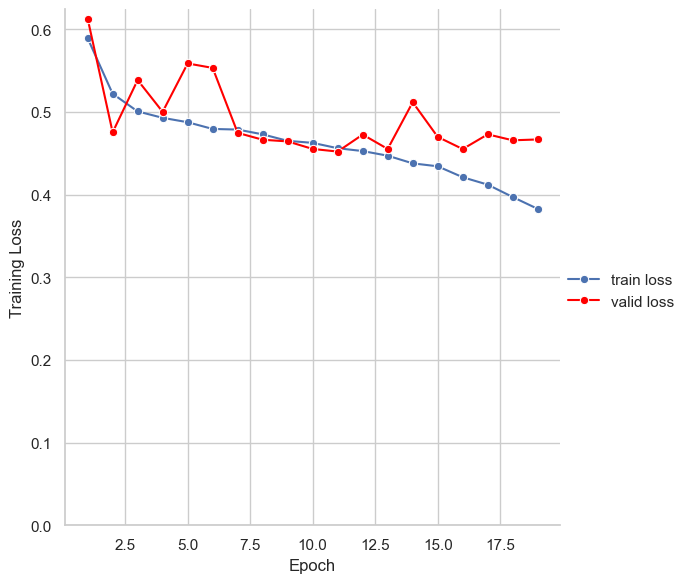

In [ ]:
df = pd.read_csv(os.path.join(SAVEDIR, f'{MODEL_TYPE}.csv'))
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=df['Epoch'],y=df['Training Loss'], marker='o', label='train loss')
g = g.map(sns.lineplot, x=df['Epoch'],y=df['Validation Loss'],color='red',marker='o', label='valid loss')
g.set(ylim=(0, None))
g.add_legend()
#plt.xticks(epochs)
plt.show()

### Resnet Accuracy + AUC-ROC work

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
def AUCstarter(model, train = True):
    model.eval()
    if train:
        loader = train_loader
    else:
        loader = test_loader
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    preds, hearts = np.array([]), np.array([])
    with torch.no_grad():
        if MODEL_TYPE == 'VanillaResNet' or MODEL_TYPE == 'SegmentedResNet':
            for i, (image, _, heart) in tqdm(enumerate(loader), total=len(loader)):
                image = image.to(device, non_blocking=True)
                pred = model(image)
                hearts = np.append(hearts, heart)
                preds = np.append(preds, pred.cpu())
            
        else:
            for i, (image, _, data, heart) in tqdm(enumerate(loader), total=len(loader)):
                image, data = image.to(device, non_blocking=True), data.to(device, non_blocking=True)
                pred = model(image, data)
                hearts = np.append(hearts, heart)
                preds = np.append(preds, pred.cpu())
    prob_preds = np.power(10,preds) / (np.power(10,preds)).sum()
    y_preds = prob_preds > (np.power(10,np.log10(400))/(np.power(10,preds)).sum())
    print(f'accuracy score: {accuracy_score(hearts, y_preds)}')
    tn, fp, fn, tp = confusion_matrix(hearts, y_preds).ravel()
    print(f'\nTN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}\n')
    cf_mat = confusion_matrix(hearts, y_preds)
    print('Confusion matrix')
    df_cm = pd.DataFrame(cf_mat/np.sum(cf_mat), index = ['Normal','Edema'],
                         columns = ['Normal','Edema'])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True,vmin=0,cmap="PiYG")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    print(cf_mat)
    return hearts, preds

100%|██████████| 1108/1108 [01:29<00:00, 12.44it/s]


accuracy score: 0.8194057916509966

TN: 3335
FP: 1383
FN: 1018
TP: 7559

Confusion matrix
[[3335 1383]
 [1018 7559]]


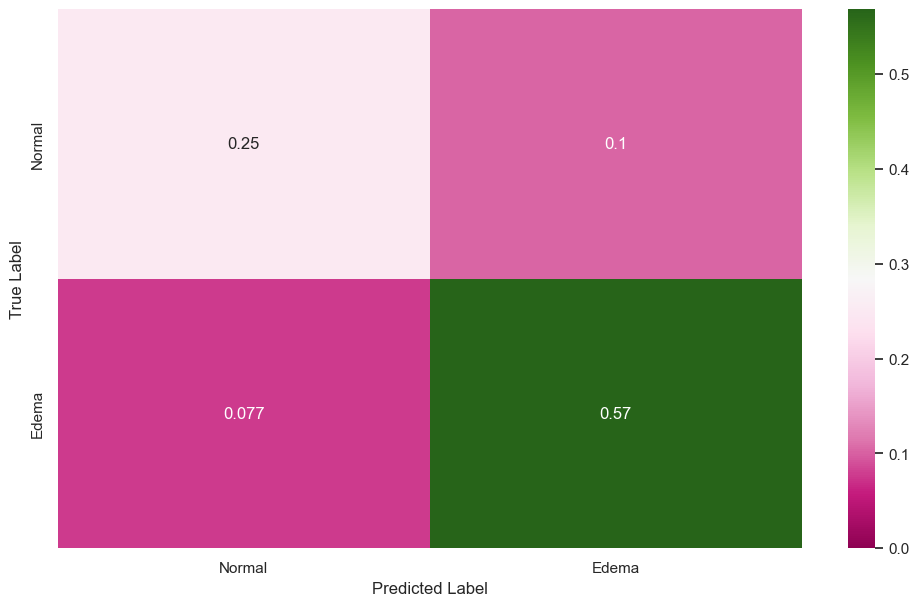

In [ ]:
#Getting the Accuracy and Confusion Matrix for the model on the Train Set
hearts, preds = AUCstarter(model)

100%|██████████| 139/139 [00:11<00:00, 12.27it/s]


accuracy score: 0.796028880866426

TN: 388
FP: 203
FN: 136
TP: 935

Confusion matrix
[[388 203]
 [136 935]]


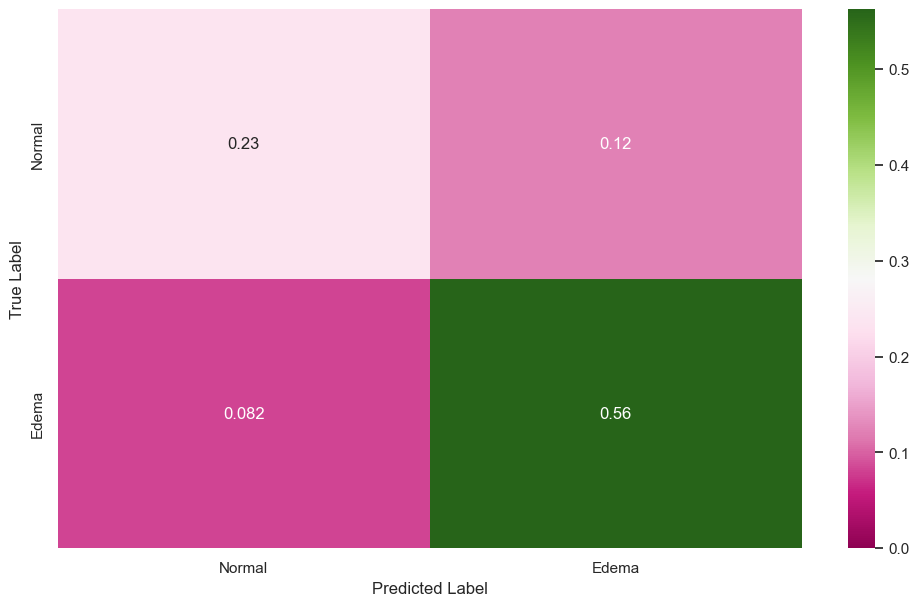

In [ ]:
#Getting the Accuracy and Confusion Matrix for the model on the Test Set
hearts2, preds2 = AUCstarter(model, train=False)

In [ ]:
#Saving the results for the model predictions on the test set
pd.DataFrame(zip(hearts2, preds2)).to_csv(os.path.join(SAVEDIR, f'{MODEL_TYPE}_preds.csv'), index=False)

### Combined AUC-ROC Curve

In [8]:
models = ['ResNet_Combo+Data2', 'VanillaResNet','VanillaResNet+Data','SegmentedResNet']
df1 = pd.read_csv(os.path.join(SAVEDIR, f'{models[0]}_preds.csv'))
df2 = pd.read_csv(os.path.join(SAVEDIR, f'{models[1]}_preds.csv'))
df3 = pd.read_csv(os.path.join(SAVEDIR, f'{models[2]}_preds.csv'))
df4 = pd.read_csv(os.path.join(SAVEDIR, f'{models[3]}_preds.csv'))

In [9]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    return roc_auc_score(true_y, y_prob)

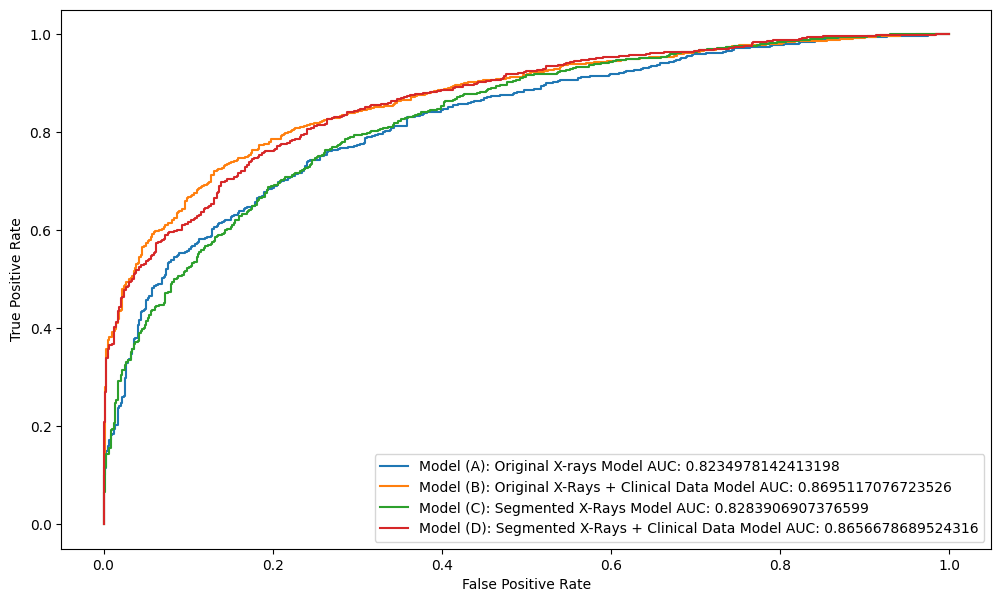

In [10]:
plt.figure(figsize = (12,7))

roc_original = plot_roc_curve(df2['0'],df2['1'])
roc_original_data = plot_roc_curve(df3['0'],df3['1'])

roc_segmented = plot_roc_curve(df4['0'],df4['1'])
roc_combo = plot_roc_curve(df1['0'],df1['1'])
plt.gca().legend((f'Model (A): Original X-rays Model AUC: {roc_original}',
f'Model (B): Original X-Rays + Clinical Data Model AUC: {roc_original_data}',
f'Model (C): Segmented X-Rays Model AUC: {roc_segmented}',
f'Model (D): Segmented X-Rays + Clinical Data Model AUC: {roc_combo}'))
plt.show()

### Pearson R Plots

In [ ]:
#collecting all the values for log10(NT-proBNP) on the test set
actuals = np.array([])
for i in np.arange(1662):
    actuals = np.append(actuals, test_set[i][1])
pd.DataFrame(actuals).to_csv(os.path.join(SAVEDIR, 'Actualbnpp.csv'), index=False)

In [ ]:
def plot_pearson_r(y_test, y_true, color = "blue"):
    corr, _ = pearsonr(y_true, y_test)
    
    sns.scatterplot(x=y_true, y=y_test, color=color)
    plt.title('r = {}'.format(np.around(corr, 3)))
    plt.show()

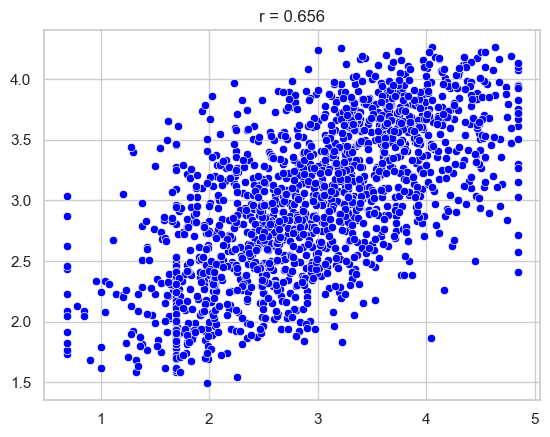

In [ ]:
#computing Scatterplot of model predictions vs. observed values for the test set
plot_pearson_r(preds2, actuals)